# Evaluation of Results
This notebook was used to evaluate all the results collected, including conducting statistical testing, bootstrapping and effect size tests.

## Initialisation
First, all necessary packages are imported, and necessary files are loaded and all results are saved into corresponding dataframes for evaluation.

### Imports

In [3]:
import os
import json
import torch
import time
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from data.attn_dataset import AttnDataset

from lova.lova import Lova

/home/leabutton/com6013-dissertation/com6013-slm-vuln-localisation/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
# Utility functions for loading data, collating batches, and evaluating models. 

def load_jsonl(path): 
    """Load a JSONL file, skipping blank or malformed lines."""
    data = [] 
    with open(path) as f: 
        for line in f: 
            line = line.strip() 
            if not line:  # skip blank lines 
                continue 
            try: 
                data.append(json.loads(line)) 
            except json.JSONDecodeError as e: 
                print(f"Skipping malformed line in {path}: {e}") 
                continue 
    return data


def collate_fn(batch):
    """
    Collate function for variable-length line representations.
    Pads to the maximum number of lines in the batch.
    """
    Xs, ys, metas = zip(*batch)

    lengths = [x.size(0) for x in Xs]

    padded_X = pad_sequence(Xs, batch_first=True)  # (B, max_len, num_layers)
    padded_y = pad_sequence(ys, batch_first=True)  # (B, max_len)

    # Build mask: True for valid (unpadded) positions
    max_len = padded_X.size(1)
    mask = torch.zeros(len(Xs), max_len, dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1

    return padded_X, padded_y, mask, metas


def evaluate_model_vs_baseline(baseline_scores, model_scores, alpha=0.05, n_bootstrap=10000, random_state=None, alternative="greater"):
    """
    Perform statistical testing and effect size calculations comparing a model vs a baseline.
    Uses Wilcoxon signed-rank test, bootstrapped confidence intervals, Cohen's d, and rank-biserial correlation.
    
    Parameters
    ----------
    baseline_scores : array-like
        Scores from the baseline model (can be a single value or per-fold).
    model_scores : array-like
        Scores from the model being evaluated (per-fold).
    alpha : float
        Significance level for hypothesis testing (default 0.05).
    n_bootstrap : int
        Number of bootstrap samples for confidence intervals (default 10000).
    random_state : int or None
        Random seed for reproducibility (default None).
        
    Returns
    -------
    dict
        Dictionary containing test statistic, p-value, significance, mean difference,
        confidence interval, Cohen's d, and rank-biserial correlation.
    """
    baseline_scores = np.array(baseline_scores, dtype=float)
    model_scores = np.array(model_scores, dtype=float)

    if baseline_scores.size == 1 and model_scores.size > 1:
        baseline_scores = np.repeat(baseline_scores, model_scores.size)

    if baseline_scores.size != model_scores.size:
        raise ValueError("Baseline and model scores must have the same length after adjustment")

    diffs = model_scores - baseline_scores

    # --- Wilcoxon test ---
    res = wilcoxon(model_scores, baseline_scores, alternative=alternative)

    # --- Bootstrapping CI ---
    rng = np.random.default_rng(random_state)
    boot_means = [np.mean(rng.choice(diffs, size=len(diffs), replace=True))
                  for _ in range(n_bootstrap)]
    ci_low = np.percentile(boot_means, 100 * alpha / 2)
    ci_high = np.percentile(boot_means, 100 * (1 - alpha / 2))

    # --- Effect sizes ---
    cohens_d = np.mean(diffs) / np.std(diffs, ddof=1)

    # Rank-biserial: if SciPy doesn't provide, compute manually
    try:
        rank_biserial = res.effect_size
    except AttributeError:
        n_pos = np.sum(diffs > 0)
        n_neg = np.sum(diffs < 0)
        n = n_pos + n_neg
        rank_biserial = (n_pos - n_neg) / n if n > 0 else np.nan

    return {
        "statistic": res.statistic,
        "p_value": res.pvalue,
        "significant": res.pvalue < alpha,
        "mean_diff": np.mean(diffs),
        "ci_low": ci_low,
        "ci_high": ci_high,
        "cohens_d": cohens_d,
        "rank_biserial": rank_biserial,
    }
    
    
def visualise_statistical_test(baseline_scores, model_scores, model_name="Model", metric="F1", n_bootstrap=10000, random_state=None):
    """
    Create visualisations for comparing a model vs a baseline:
      1. Paired line plot
      2. Per-fold difference bar chart
      3. Bootstrap distribution of differences
      4. Boxplot of model folds with baseline line
      
    Parameters
    ----------
    baseline_scores : array-like
        Scores from the baseline model (can be a single value or per-fold).
    model_scores : array-like
        Scores from the model being evaluated (per-fold).
    model_name : str
        Name of the model for labeling (default "Model").
    metric : str
        Name of the metric being evaluated (default "F1").
    n_bootstrap : int
        Number of bootstrap samples for confidence intervals (default 10000).
    random_state : int or None
        Random seed for reproducibility (default None).
        
    Returns
    -------
    None
        Displays the plots and saves the figure as a PNG file.
    """
    baseline_scores = np.array(baseline_scores, dtype=float)
    model_scores = np.array(model_scores, dtype=float)

    # Repeat baseline if only single value
    if baseline_scores.size == 1 and model_scores.size > 1:
        baseline_scores = np.repeat(baseline_scores, model_scores.size)

    diffs = model_scores - baseline_scores

    # --- Bootstrap for CI ---
    rng = np.random.default_rng(random_state)
    boot_means = [np.mean(rng.choice(diffs, size=len(diffs), replace=True))
                  for _ in range(n_bootstrap)]
    ci_low = np.percentile(boot_means, 2.5)
    ci_high = np.percentile(boot_means, 97.5)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    # 1. Paired line plot
    for i, (b, m) in enumerate(zip(baseline_scores, model_scores), start=1):
        axes[0].plot([0, 1], [b, m], marker="o", color="grey", alpha=0.7)
    axes[0].scatter([0], [baseline_scores.mean()], color="red", s=100, zorder=3, label="Baseline (0-shot)")
    axes[0].scatter([1], [model_scores.mean()], color="blue", s=100, zorder=3, label=model_name)
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(["Baseline", model_name])
    axes[0].set_ylabel(f"{metric} Score")
    axes[0].set_title("Paired Scores (Wilcoxon Design)")
    axes[0].legend()
    axes[0].grid(axis="y", linestyle="--", alpha=0.6)

    # 2. Differences plot
    axes[1].bar(range(1, len(diffs)+1), diffs, color="steelblue", edgecolor="black")
    axes[1].axhline(0, color="red", linestyle="--", label="No Difference")
    axes[1].set_xlabel("Fold")
    axes[1].set_ylabel(f"{metric} Difference ({model_name} − Baseline)")
    axes[1].set_title("Per-Fold Differences")
    axes[1].legend()

    # 3. Bootstrap distribution
    axes[2].hist(boot_means, bins=30, color="lightblue", edgecolor="black", alpha=0.7)
    axes[2].axvline(np.mean(diffs), color="blue", linestyle="-", linewidth=2, label="Observed mean diff")
    axes[2].axvline(ci_low, color="red", linestyle="--", label=f"95% CI lower ({ci_low:.2f})")
    axes[2].axvline(ci_high, color="red", linestyle="--", label=f"95% CI upper ({ci_high:.2f})")
    axes[2].set_title("Bootstrap Distribution of Differences")
    axes[2].set_xlabel(f"Mean difference in {metric}")
    axes[2].set_ylabel("Frequency")
    axes[2].legend()

    # 4. Boxplot vs baseline
    axes[3].boxplot(model_scores, positions=[0], widths=0.5, patch_artist=True,
                    boxprops=dict(facecolor="lightblue", color="black"),
                    medianprops=dict(color="black"))
    axes[3].axhline(baseline_scores.mean(), color="red", linestyle="--", 
                    label=f"Baseline = {baseline_scores.mean():.2f}")
    axes[3].set_xticks([0])
    axes[3].set_xticklabels([model_name])
    axes[3].set_ylabel(f"{metric} Score")
    axes[3].set_title("Model Distribution vs Baseline")
    axes[3].legend()

    plt.tight_layout()
    plt.show()
    
    # save figure
    fig.savefig(f"./figs/{model_name.lower().replace(' ', '_')}_vs_baseline_comparison.png", dpi=300)


def cohens_d_paired(a, b):
    """Paired Cohen's d (mean of differences / sd of differences)."""
    diffs = np.asarray(b, float) - np.asarray(a, float)
    return np.mean(diffs) / np.std(diffs, ddof=1)


def bootstrap_ci_mean_diff(a, b, n_boot=10000, alpha=0.05, random_state=None):
    """Bootstrap CI for mean(b - a)."""
    rng = np.random.default_rng(random_state)
    diffs = np.asarray(b, float) - np.asarray(a, float)
    boots = [np.mean(rng.choice(diffs, size=len(diffs), replace=True)) for _ in range(n_boot)]
    lo = np.percentile(boots, 100*alpha/2)
    hi = np.percentile(boots, 100*(1 - alpha/2))
    return float(np.mean(diffs)), float(lo), float(hi)


def rank_biserial_from_pairs(a, b):
    """Rank-biserial from sign of paired diffs (robust for older SciPy)."""
    diffs = np.asarray(b, float) - np.asarray(a, float)
    n_pos = np.sum(diffs > 0)
    n_neg = np.sum(diffs < 0)
    n = n_pos + n_neg
    return (n_pos - n_neg) / n if n > 0 else np.nan


def wilcoxon_greater(a, b):
    """One-sided Wilcoxon for H1: b > a."""
    res = wilcoxon(np.asarray(b, float), np.asarray(a, float), alternative="greater")
    return res.statistic, res.pvalue


def holm_bonferroni(pvals, alpha=0.05):
    """Return Holm–Bonferroni adjusted significance decisions in order of input."""
    order = np.argsort(pvals)
    m = len(pvals)
    decisions = [False]*m
    for rank, idx in enumerate(order, start=1):
        if pvals[idx] <= alpha / (m - rank + 1):
            decisions[idx] = True
        else:
            # once a test is not significant, larger p's won't be either
            # but we still return the boolean list
            pass
    return decisions


### Setup

In [5]:
# Directories
cv_dir = "data/cv"
model_name = "deepseek-ai/deepseek-coder-1.3b-base"
classifier_root = f"cache/attn_classifiers/{model_name.replace('/', '_')}"
attn_cache = "cache/attn_matrices"
baseline_dir = "results"
measure_dir = "measure"

# Create output directory for figures
os.makedirs("./figs", exist_ok=True)


# Log files from overhead measurement
files = {
    "Baseline": os.path.join(measure_dir, "baseline_logs.jsonl"),
    "LoVA Precompute": os.path.join(measure_dir, "lova_precompute.jsonl"),
    "LoVA Train/Infer": os.path.join(measure_dir, "lova_train_infer.jsonl"),
}

logs = {}
for name, path in files.items():
    if os.path.exists(path):
        logs[name] = pd.read_json(path, lines=True)
        print(f"[INFO] Loaded {name}: {len(logs[name])} entries")
    else:
        print(f"[WARN] File not found: {path}")

# Colours to match diagrams in report
palette = ["#809EC2", "#9C85C0", "#D092A7", "#E7BC29", "#F3A447", "#A5B592"]

# Mapping model short names to full names for display
name_map = {
    "phi_1_5": "Phi-1.5",
    "tinyllama": "TinyLlama",
    "deepseek_coder_1_3b": "DeepSeek-Coder 1.3B",
    "deepseek_coder_6_7b": "DeepSeek-Coder 6.7B",
    "codellama_7b": "CodeLlama 7B",
    "starcoder2_3b": "StarCoder2 3B",
    "starcoder2_7b": "StarCoder2 7B",
}

[INFO] Loaded Baseline: 596 entries
[INFO] Loaded LoVA Precompute: 600 entries
[INFO] Loaded LoVA Train/Infer: 10 entries


In [6]:
# Load test set
test_path = os.path.join(cv_dir, "fold_5", "test.json")
with open(test_path) as f:
    test_json = json.load(f)
test_ids = {ex["id"] for ex in test_json}

print(f"Test set size: {len(test_ids)} examples")

Test set size: 1397 examples


### Zero-Shot Baseline Results

In [7]:
baseline_results = []

# Iterate only over 0_shot baselines
zero_shot_dir = os.path.join(baseline_dir, "0_shot")
for fname in os.listdir(zero_shot_dir):
    if not fname.endswith("_baseline_predictions.jsonl"):
        continue
    
    model = fname.replace("_baseline_predictions.jsonl", "")
    shots = "0_shot"
    
    path = os.path.join(zero_shot_dir, fname)
    preds = load_jsonl(path)
    
    # Filter down to test set
    preds = [ex for ex in preds if ex["id"] in test_ids]
    
    if not preds:
        print(f"No matching test predictions for {model} ({shots})")
        continue
    
    # Metrics containers
    y_true = []
    y_pred = []
    exact_matches = 0
    
    for ex in preds:
        true_lines = ex["true_lines"]
        pred_lines = ex["predicted_lines"]
        
        # === Per-line labels for precision/recall/F1 ===
        max_line = max(true_lines + pred_lines + [0])
        for i in range(1, max_line + 1):
            y_true.append(1 if i in true_lines else 0)
            y_pred.append(1 if i in pred_lines else 0)
        
        # === Exact match (per example) ===
        if set(pred_lines) == set(true_lines):
            exact_matches += 1
    
    # Aggregate metrics
    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    em = (exact_matches / len(preds)) * 100
    
    baseline_results.append({
        "shots": shots,
        "model": model,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "exact_match": em,
    })

baseline_df = pd.DataFrame(baseline_results)
baseline_df


Skipping malformed line in results/0_shot/starcoder2_7b_baseline_predictions.jsonl: Expecting ',' delimiter: line 1 column 952 (char 951)
Skipping malformed line in results/0_shot/codellama_7b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/0_shot/codellama_7b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/0_shot/codellama_7b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/0_shot/codellama_7b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/0_shot/codellama_7b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)


,shots,model,precision,recall,f1,exact_match
0,0_shot,starcoder2_7b,1.144492,0.333960,0.517046,1.861131
1,0_shot,phi_1_5,21.621622,1.059603,2.020202,20.229008
2,0_shot,tinyllama,0.000000,0.000000,0.000000,22.137405
3,0_shot,deepseek_coder_1_3b,6.466165,5.695364,6.056338,3.435115
4,0_shot,codellama_7b,18.732025,31.266959,23.428214,5.082319
5,0_shot,deepseek_coder_6_7b,25.191571,21.957838,23.463812,12.956335
6,0_shot,starcoder2_3b,7.142857,1.192053,2.043133,17.175573


### One-Shot and Three-Shot Results (for single SLM)

In [8]:
deepseek_results = []

# Iterate over 0_shot, 1_shot, and 3_shot DeepSeek results
for shots in ["0_shot", "1_shot", "3_shot"]:
    shot_dir = os.path.join("results", shots)
    fname = "deepseek_coder_1_3b_baseline_predictions.jsonl"
    path = os.path.join(shot_dir, fname)
    
    if not os.path.exists(path):
        print(f"Missing file for {shots}: {fname}")
        continue

    preds = load_jsonl(path)

    # Filter down to test set
    preds = [ex for ex in preds if ex["id"] in test_ids]

    if not preds:
        print(f"No matching test predictions for DeepSeek 1.3B ({shots})")
        continue

    # True labels and predicted labels
    y_true = []
    y_pred = []
    exact_matches = 0

    for ex in preds:
        true_lines = ex["true_lines"]
        pred_lines = ex["predicted_lines"]

        # Per-line labels for precision/recall/F1
        max_line = max(true_lines + pred_lines + [0])
        for i in range(1, max_line + 1):
            y_true.append(1 if i in true_lines else 0)
            y_pred.append(1 if i in pred_lines else 0)

        # Exact match (per example)
        if set(pred_lines) == set(true_lines):
            exact_matches += 1

    precision = precision_score(y_true, y_pred, zero_division=0) * 100
    recall = recall_score(y_true, y_pred, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    em = (exact_matches / len(preds)) * 100

    deepseek_results.append({
        "shots": shots,
        "model": "deepseek_coder_1_3b",
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "exact_match": em,
    })

deepseek_df = pd.DataFrame(deepseek_results)
deepseek_df

Skipping malformed line in results/1_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/1_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/1_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/1_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/3_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/3_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/3_shot/deepseek_coder_1_3b_baseline_predictions.jsonl: Expecting value: line 1 column 1 (char 0)
Skipping malformed line in results/3_shot/deepseek_coder_1_3b_baseline_predi

,shots,model,precision,recall,f1,exact_match
0,0_shot,deepseek_coder_1_3b,6.466165,5.695364,6.056338,3.435115
1,1_shot,deepseek_coder_1_3b,16.900843,8.789144,11.564346,7.951289
2,3_shot,deepseek_coder_1_3b,18.617021,0.730689,1.406187,21.203438


### LoVA Results (for single SLM)

In [9]:
shots_list = [0, 1, 3] 
classifiers = [
    "BiLSTM_small", "BiLSTM_moderate", "BiLSTM_large",
    "LSTM_small", "LSTM_moderate", "LSTM_large",
    "LogReg_default", "LogReg_lowC", "LogReg_l1",
    "XGB_small", "XGB_moderate", "XGB_large",
]
device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
results = []

for shots in shots_list:
    for clf_name in classifiers:
        clf_dir = os.path.join(classifier_root, f"{shots}_shot", clf_name)
        if not os.path.exists(clf_dir):
            continue  # skip if you didn’t train it

        print(f"=== Evaluating {clf_name} ({shots}_shot) ===")

        for fold in range(5):
            # Test dataset
            test_dataset = AttnDataset(
                json_path=test_path,
                model_name=model_name,
                cache_dir=attn_cache,
                shots=shots,
                device=device,
            )
            test_loader = DataLoader(
                test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn
            )

            # Init Lova with same classifier config
            lova = Lova(device=device, shots=shots, classifier_name=clf_name)

            # Load checkpoint (pt for torch, pkl for sklearn/xgb)
            pt_path = os.path.join(clf_dir, f"fold_{fold}.pt")
            pkl_path = os.path.join(clf_dir, f"fold_{fold}.pkl")

            if os.path.exists(pt_path):
                input_dim = next(iter(test_loader))[0].size(-1)
                lova.load_classifier(pt_path, input_dim=input_dim)
            elif os.path.exists(pkl_path):
                input_dim = next(iter(test_loader))[0].size(-1)
                lova.load_classifier(pkl_path, input_dim=input_dim)
            else:
                print(f"Missing model for {clf_name}, fold {fold}")
                continue

            # Evaluate
            metrics = lova.evaluate(test_loader)
            metrics.update({
                "shots": shots,
                "classifier": clf_name,
                "fold": fold,
            })
            print(metrics)
            results.append(metrics)


=== Evaluating BiLSTM_small (0_shot) ===
{'precision': 25.299315849486888, 'recall': 38.908373520385794, 'f1': 30.661599585420625, 'exact_match': 9.663564781675017, 'shots': 0, 'classifier': 'BiLSTM_small', 'fold': 0}
{'precision': 27.918968692449354, 'recall': 33.231039017974574, 'f1': 30.34427542033627, 'exact_match': 13.815318539727988, 'shots': 0, 'classifier': 'BiLSTM_small', 'fold': 1}
{'precision': 27.55332061730536, 'recall': 34.83121437965804, 'f1': 30.7677413108723, 'exact_match': 13.385826771653544, 'shots': 0, 'classifier': 'BiLSTM_small', 'fold': 2}
{'precision': 23.111550285463327, 'recall': 46.142042963612454, 'f1': 30.79736649597659, 'exact_match': 12.956335003579097, 'shots': 0, 'classifier': 'BiLSTM_small', 'fold': 3}
{'precision': 26.94529391777098, 'recall': 34.76545374835599, 'f1': 30.35987748851455, 'exact_match': 13.09949892627058, 'shots': 0, 'classifier': 'BiLSTM_small', 'fold': 4}
=== Evaluating BiLSTM_moderate (0_shot) ===
{'precision': 26.391000304043782, 'r

In [38]:
df = pd.DataFrame(results)
df.groupby(["shots", "classifier"]).agg(["mean", "std"])

lova_non_agg_df = df.copy()

# Group by shots + classifier, compute mean and std
lova_agg_df = df.groupby(["shots", "classifier"]).agg(
    precision_mean=("precision", "mean"),
    precision_std=("precision", "std"),
    recall_mean=("recall", "mean"),
    recall_std=("recall", "std"),
    f1_mean=("f1", "mean"),
    f1_std=("f1", "std"),
    exact_match_mean=("exact_match", "mean"),
    exact_match_std=("exact_match", "std")
).reset_index()

lova_agg_df

,shots,classifier,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,exact_match_mean,exact_match_std
0,0,BiLSTM_large,25.532893,1.832223,37.996493,4.917231,30.321378,0.652572,12.884753,1.021141
1,0,BiLSTM_moderate,25.037453,0.985890,39.982464,1.483223,30.762199,0.485210,11.925555,1.249715
2,0,BiLSTM_small,26.165690,1.980256,37.575625,5.231253,30.586172,0.219649,12.584109,1.665262
3,0,LSTM_large,25.093016,0.968934,37.198597,2.218711,29.917723,0.355887,10.880458,1.123860
4,0,LSTM_moderate,25.919167,1.443934,36.378781,3.441494,30.141840,0.174568,11.939871,0.926979
5,0,LSTM_small,25.689280,2.156492,35.177554,4.924623,29.403984,0.441298,11.224052,1.265807
6,0,LogReg_default,44.872892,0.544408,1.858834,0.042164,3.569719,0.077691,21.746600,0.117621
7,0,LogReg_l1,45.167676,0.637008,1.907058,0.098030,3.659346,0.181066,21.832498,0.087670
8,0,LogReg_lowC,45.306989,1.204319,1.385357,0.018340,2.688423,0.033177,22.247674,0.093331
9,0,XGB_large,61.910739,4.432504,2.108724,0.115368,4.078048,0.220173,23.278454,0.279078


In [39]:
lova_non_agg_df

,precision,recall,f1,exact_match,shots,classifier,fold
0,25.299316,38.908374,30.661600,9.663565,0,BiLSTM_small,0
1,27.918969,33.231039,30.344275,13.815319,0,BiLSTM_small,1
2,27.553321,34.831214,30.767741,13.385827,0,BiLSTM_small,2
3,23.111550,46.142043,30.797366,12.956335,0,BiLSTM_small,3
4,26.945294,34.765454,30.359877,13.099499,0,BiLSTM_small,4
...,...,...,...,...,...,...,...
175,54.761905,0.504275,0.999348,22.834646,3,XGB_large,0
176,62.857143,0.482350,0.957354,22.834646,3,XGB_large,1
177,66.666667,0.570050,1.130435,22.977810,3,XGB_large,2
178,62.500000,0.548125,1.086720,22.691482,3,XGB_large,3


## RQ1: Can self-attention mechanisms in SLMs effectively be leveraged to yield a statistically significant increase in technical performance over a standard zero-shot prompting baseline?

### Plot the Precision, Recall, F1 and Exact Match for the baseline results

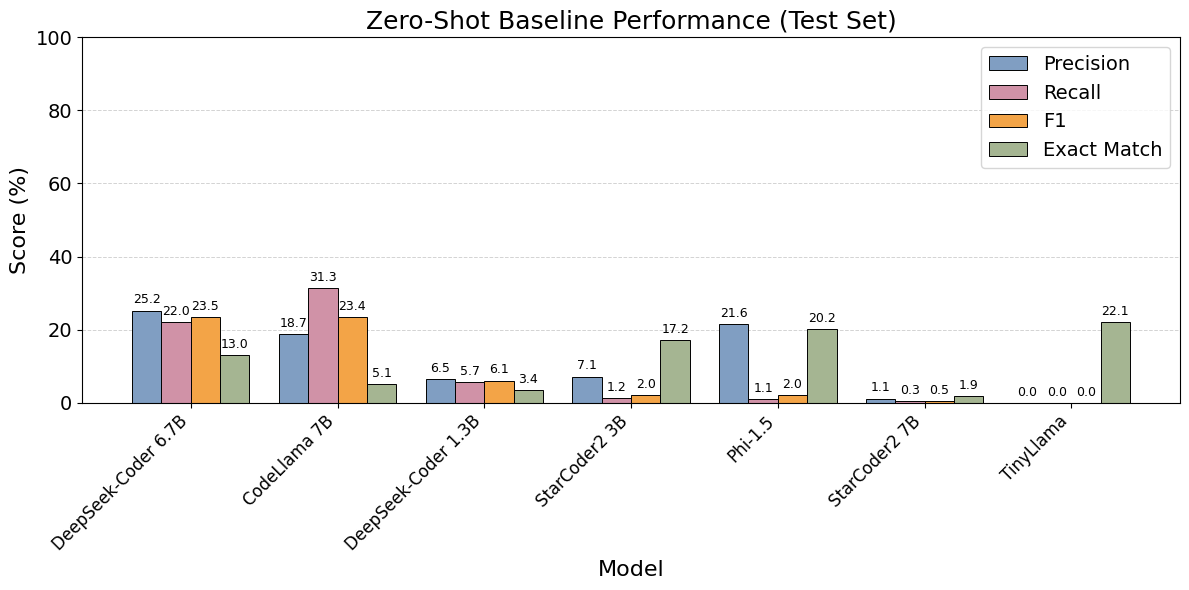

In [12]:
# Sort by F1 score (descending)
plot_df = baseline_df.sort_values("f1", ascending=False)
plot_df["model_readable"] = plot_df["model"].map(name_map).fillna(plot_df["model"])

# Bar settings
x = np.arange(len(plot_df))  # positions
width = 0.2  # narrower bars since we have 4 metrics now

fig, ax = plt.subplots(figsize=(12, 6))

# Bars for precision, recall, f1, exact match
bars1 = ax.bar(x - 1.5*width, plot_df["precision"], 
                width, label="Precision", 
                color=palette[0],
                edgecolor="black", linewidth=0.7)

bars2 = ax.bar(x - 0.5*width, plot_df["recall"], 
                width, label="Recall", 
                color=palette[2],
                edgecolor="black", linewidth=0.7)

bars3 = ax.bar(x + 0.5*width, plot_df["f1"], 
                width, label="F1", 
                color=palette[4],
                edgecolor="black", linewidth=0.7)

bars4 = ax.bar(x + 1.5*width, plot_df["exact_match"], 
                width, label="Exact Match", 
                color=palette[5],
                edgecolor="black", linewidth=0.7)

# Add labels above *all* bars (keep small font size)
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)  # small

# Format plot with larger fonts
ax.set_ylabel("Score (%)", fontsize=16)
ax.set_xlabel("Model", fontsize=16)
ax.set_title("Zero-Shot Baseline Performance (Test Set)", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(plot_df["model_readable"], rotation=45, ha="right", fontsize=12)

ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=14)

# Add grey horizontal grid lines
ax.yaxis.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
ax.set_axisbelow(True)  # ensure grid lines are behind bars

plt.ylim(0, 100)  # percent scale
plt.tight_layout()
plt.show()

# Save
fig.savefig("./figs/zero_shot_baseline_performance.png", dpi=300)

In [13]:
plot_df

,shots,model,precision,recall,f1,exact_match,model_readable
5,0_shot,deepseek_coder_6_7b,25.191571,21.957838,23.463812,12.956335,DeepSeek-Coder 6.7B
4,0_shot,codellama_7b,18.732025,31.266959,23.428214,5.082319,CodeLlama 7B
3,0_shot,deepseek_coder_1_3b,6.466165,5.695364,6.056338,3.435115,DeepSeek-Coder 1.3B
6,0_shot,starcoder2_3b,7.142857,1.192053,2.043133,17.175573,StarCoder2 3B
1,0_shot,phi_1_5,21.621622,1.059603,2.020202,20.229008,Phi-1.5
0,0_shot,starcoder2_7b,1.144492,0.333960,0.517046,1.861131,StarCoder2 7B
2,0_shot,tinyllama,0.000000,0.000000,0.000000,22.137405,TinyLlama


In [14]:
# Sort by F1 score (descending)
plot_df = baseline_df.sort_values("f1", ascending=False)
plot_df["model_readable"] = plot_df["model"].map(name_map).fillna(plot_df["model"])

metrics = ["precision", "recall", "f1", "exact_match"]
titles = ["Precision", "Recall", "F1 Score", "Exact Match"]
colors = [palette[0], palette[2], palette[4], palette[5]]

x = np.arange(len(plot_df))  # x positions

for metric, title, color in zip(metrics, titles, colors):
    fig, ax = plt.subplots(figsize=(6, 4))

    bars = ax.bar(x, plot_df[metric],
                  color=color, edgecolor="black", linewidth=0.7)

    # Add labels on top
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

    ax.set_ylabel("Score (%)")
    ax.set_title(f"Zero-Shot Baseline: {title} (Test Set)")
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df["model_readable"], rotation=45, ha="right")
    ax.yaxis.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
    ax.set_axisbelow(True)

    plt.tight_layout()

    # Save each plot separately
    save_path = f"./figs/zero_shot_baseline_{metric}.png"
    fig.savefig(save_path, dpi=300)
    plt.close(fig)  # close so only one figure is open at a time

    print(f"Saved {save_path}")

Saved ./figs/zero_shot_baseline_precision.png
Saved ./figs/zero_shot_baseline_recall.png
Saved ./figs/zero_shot_baseline_f1.png
Saved ./figs/zero_shot_baseline_exact_match.png


We select DeepSeek Coder 1.3B as the model to proceed experimentation with, as the best performer of the smaller cluster of models assessed.

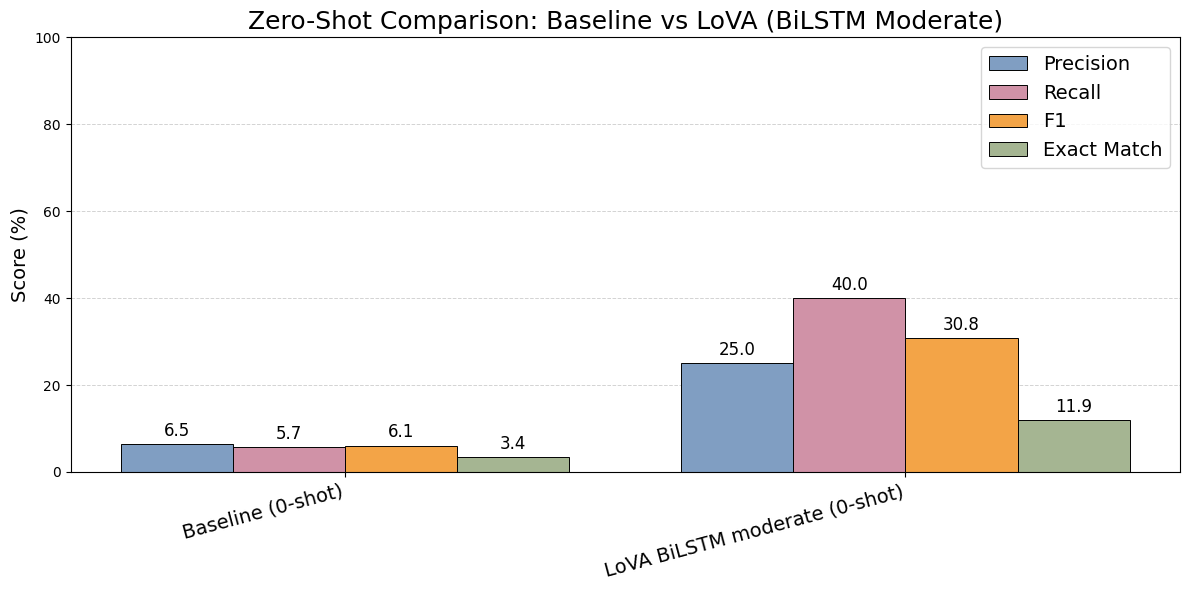

In [15]:
# --- Filter down to the relevant rows ---
# DeepSeek baseline (0-shot)
deepseek_row = deepseek_df.query("shots == '0_shot' and model == 'deepseek_coder_1_3b'")

# Lova BiLSTM moderate (0-shot) — adjust classifier name if different
lova_df = pd.DataFrame(results)  # if not already in a DataFrame
lova_row = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")

# --- Combine into one DataFrame ---
compare_df = pd.DataFrame([
    {
        "model": "Baseline (0-shot)",
        "precision": deepseek_row["precision"].values[0],
        "recall": deepseek_row["recall"].values[0],
        "f1": deepseek_row["f1"].values[0],
        "exact_match": deepseek_row["exact_match"].values[0],
        "precision_err": 0.0,  # no folds
        "recall_err": 0.0,
        "f1_err": 0.0,
        "exact_match_err": 0.0,
    },
    {
        "model": "LoVA BiLSTM moderate (0-shot)",
        "precision": lova_row["precision"].mean(),  # average across folds
        "recall": lova_row["recall"].mean(),
        "f1": lova_row["f1"].mean(),
        "exact_match": lova_row["exact_match"].mean(),
    }
])

# --- Plot grouped bar chart ---
x = np.arange(len(compare_df))  # model positions
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - 1.5*width, compare_df["precision"], 
               width, label="Precision", 
               color=palette[0], edgecolor="black", linewidth=0.7)

bars2 = ax.bar(x - 0.5*width, compare_df["recall"],    
               width, label="Recall",    
               color=palette[2], edgecolor="black", linewidth=0.7)

bars3 = ax.bar(x + 0.5*width, compare_df["f1"],        
               width, label="F1",        
               color=palette[4], edgecolor="black", linewidth=0.7)

bars4 = ax.bar(x + 1.5*width, compare_df["exact_match"], 
               width, label="Exact Match", 
               color=palette[5], edgecolor="black", linewidth=0.7)

# Add labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha="center", va="bottom", fontsize=12)

ax.set_ylabel("Score (%)", fontsize=14)
ax.set_title("Zero-Shot Comparison: Baseline vs LoVA (BiLSTM Moderate)", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(compare_df["model"], rotation=15, ha="right", fontsize=14)
ax.legend(fontsize=14)

ax.yaxis.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
ax.set_axisbelow(True)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Save
fig.savefig("./figs/zero_shot_comparison_lova_vs_baseline.png", dpi=300)

In [27]:
compare_df

,model,precision,recall,f1,exact_match,precision_err,recall_err,f1_err,exact_match_err
0,Baseline (0-shot),6.466165,5.695364,6.056338,3.435115,0.0,0.0,0.0,0.0
1,LoVA BiLSTM moderate (0-shot),25.037453,39.982464,30.762199,11.925555,NaN,NaN,NaN,NaN


In [40]:
# Precision Statistics
baseline_precision = deepseek_df.query("shots == '0_shot'")["precision"].values[0]
lova_precisions = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")["precision"].values

res = evaluate_model_vs_baseline(baseline_precision, lova_precisions)

# format and print results
print("Precision Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)")
for k, v in res.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Precision Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)
  statistic: 15.0000
  p_value: 0.0312
  significant: True
  mean_diff: 18.5713
  ci_low: 17.8544
  ci_high: 19.3101
  cohens_d: 18.8371
  rank_biserial: 1.0000


In [41]:
# Recall Statistics
baseline_recall = deepseek_df.query("shots == '0_shot'")["recall"].values[0]
lova_recalls = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")["recall"].values

res = evaluate_model_vs_baseline(baseline_recall, lova_recalls)

# format and print results
print("Recall Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)")
for k, v in res.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Recall Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)
  statistic: 15.0000
  p_value: 0.0312
  significant: True
  mean_diff: 34.2871
  ci_low: 33.1166
  ci_high: 35.4094
  cohens_d: 23.1166
  rank_biserial: 1.0000


In [43]:
# F1 Statistics
baseline_f1 = deepseek_df.query("shots == '0_shot'")["f1"].values[0]
lova_f1s = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")["f1"].values

res = evaluate_model_vs_baseline(baseline_f1, lova_f1s)

# format print
print("F1 Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)")
for k, v in res.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

F1 Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)
  statistic: 15.0000
  p_value: 0.0312
  significant: True
  mean_diff: 24.7059
  ci_low: 24.2700
  ci_high: 24.9961
  cohens_d: 50.9178
  rank_biserial: 1.0000


In [42]:
# Exact Match Statistics
baseline_em = deepseek_df.query("shots == '0_shot'")["exact_match"].values[0]
lova_ems = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")["exact_match"].values   

res = evaluate_model_vs_baseline(baseline_em, lova_ems)

# format print
print("Exact Match Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)")
for k, v in res.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

Exact Match Comparison: LoVA BiLSTM Moderate vs Baseline (0-shot)
  statistic: 15.0000
  p_value: 0.0312
  significant: True
  mean_diff: 8.4904
  ci_low: 7.6744
  ci_high: 9.6071
  cohens_d: 6.7939
  rank_biserial: 1.0000


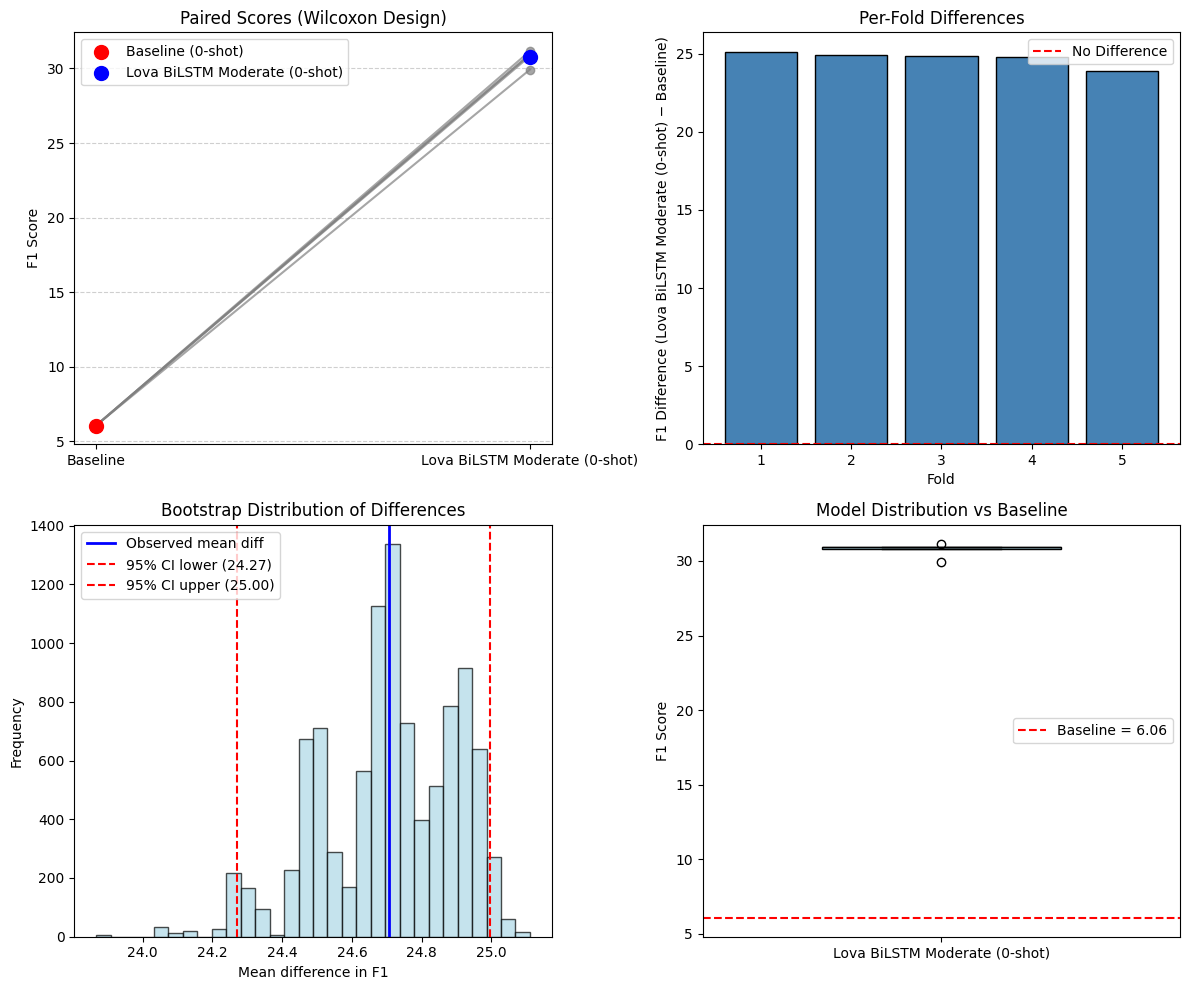

In [18]:
baseline_f1 = deepseek_df.query("shots == '0_shot'")["f1"].values[0]
lova_f1s = lova_df.query("shots == 0 and classifier == 'BiLSTM_moderate'")["f1"].values

visualise_statistical_test(baseline_f1, lova_f1s, model_name="Lova BiLSTM Moderate (0-shot)", metric="F1")

## RQ2: What is the impact of changing the number of shots used?

In [19]:
# Clean up DeepSeek df so shots are integers
deepseek_clean = deepseek_df.copy()
deepseek_clean["shots"] = deepseek_clean["shots"].str.replace("_shot", "").astype(int)

bilstm_moderate_df = df.query("classifier == 'BiLSTM_moderate'").copy()
# aggregate by shots
bilstm_moderate_df = bilstm_moderate_df.groupby("shots").agg(
    precision_mean=("precision", "mean"),
    precision_std=("precision", "std"),
    recall_mean=("recall", "mean"),
    recall_std=("recall", "std"),
    f1_mean=("f1", "mean"),
    f1_std=("f1", "std"),
    exact_match_mean=("exact_match", "mean"),
    exact_match_std=("exact_match", "std")
).reset_index()
                                        

# Add model/approach column to bilstm df so it's consistent
bilstm_clean = bilstm_moderate_df.copy()
bilstm_clean = bilstm_clean.rename(columns={
    "classifier": "model",
    "precision_mean": "precision",
    "recall_mean": "recall",
    "f1_mean": "f1",
    "exact_match_mean": "exact_match"
})
bilstm_clean["model"] = "BiLSTM_moderate (LoVA)"
bilstm_clean["type"] = "lova"

deepseek_clean["type"] = "baseline"

# Merge into single dataframe
combined_df = pd.concat([deepseek_clean[["shots","model","precision","recall","f1","exact_match","type"]],
                         bilstm_clean[["shots","model","precision","recall","f1","exact_match","type"]]],
                        ignore_index=True)

display(combined_df)


,shots,model,precision,recall,f1,exact_match,type
0,0,deepseek_coder_1_3b,6.466165,5.695364,6.056338,3.435115,baseline
1,1,deepseek_coder_1_3b,16.900843,8.789144,11.564346,7.951289,baseline
2,3,deepseek_coder_1_3b,18.617021,0.730689,1.406187,21.203438,baseline
3,0,BiLSTM_moderate (LoVA),25.037453,39.982464,30.762199,11.925555,lova
4,1,BiLSTM_moderate (LoVA),25.530644,35.811106,29.743798,15.275591,lova
5,3,BiLSTM_moderate (LoVA),23.900663,36.320982,27.933202,14.359341,lova


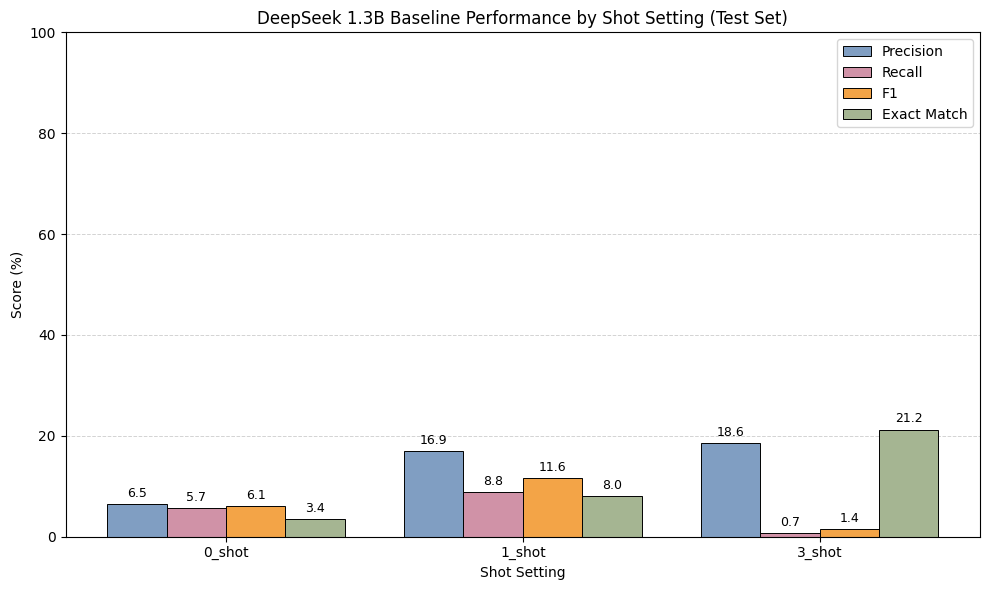

In [20]:
# Sort shots in numeric order (0, 1, 3)
plot_df = deepseek_df.copy()
plot_df["shot_num"] = plot_df["shots"].str.replace("_shot", "").astype(int)
plot_df = plot_df.sort_values("shot_num")

# Bar settings
x = np.arange(len(plot_df))  # positions
width = 0.2  # narrower bars since we have 4 metrics

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - 1.5*width, plot_df["precision"], 
               width, label="Precision", 
               color=palette[0], edgecolor="black", linewidth=0.7)

bars2 = ax.bar(x - 0.5*width, plot_df["recall"], 
               width, label="Recall", 
               color=palette[2], edgecolor="black", linewidth=0.7)

bars3 = ax.bar(x + 0.5*width, plot_df["f1"], 
               width, label="F1", 
               color=palette[4], edgecolor="black", linewidth=0.7)

bars4 = ax.bar(x + 1.5*width, plot_df["exact_match"], 
               width, label="Exact Match", 
               color=palette[5], edgecolor="black", linewidth=0.7)

# Add labels above all bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

# Formatting
ax.set_ylabel("Score (%)")
ax.set_xlabel("Shot Setting")
ax.set_title("DeepSeek 1.3B Baseline Performance by Shot Setting (Test Set)")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["shots"], rotation=0)
ax.legend()

ax.yaxis.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
ax.set_axisbelow(True)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()


In [21]:
# Define titles for each metric
metrics = ["precision", "recall", "f1", "exact_match"]
titles = {
    "precision": "Precision",
    "recall": "Recall",
    "f1": "F1 Score",
    "exact_match": "Exact Match"
}

# Loop through metrics and plot
for metric in metrics:
    plt.figure(figsize=(5, 4))
    
    # Baseline (DeepSeek)
    baseline_df = combined_df.query("type == 'baseline'").sort_values("shots")
    plt.plot(
        baseline_df["shots"],
        baseline_df[metric],
        marker="o", color="red", label="Baseline (DeepSeek 1.3B)"
    )
    
    # LoVA (BiLSTM Moderate)
    lova_df = combined_df.query("type == 'lova'").sort_values("shots")
    plt.errorbar(
        lova_df["shots"],
        lova_df[metric],
        yerr=bilstm_moderate_df[f"{metric}_std"],  # error bars from std
        marker="o", color="blue", label="LoVA BiLSTM Moderate", capsize=4
    )
    
    # Formatting
    plt.xticks([0, 1, 3], ["0-shot", "1-shot", "3-shot"])
    plt.ylabel("Score (%)")
    plt.title(f"{titles[metric]} Across Shots")
    plt.ylim(0, 100)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"./figs/{metric}_baseline_vs_lova.png", dpi=300)
    plt.close()


In [51]:
# Get per-fold LoVA results for each metric and shot
lova_df = pd.DataFrame(results)  
lova_df = lova_df.query("classifier == 'BiLSTM_moderate'").copy()

metrics = ["precision", "recall", "f1", "exact_match"]

# Build a nested dictionary: metrics -> shots -> values
scores_by_metric = {
    metric: {
        0: lova_df.query("shots == 0")[metric].values,
        1: lova_df.query("shots == 1")[metric].values,
        3: lova_df.query("shots == 3")[metric].values,
    }
    for metric in metrics
}

# Run pairwise comparisons (two-sided) for each metric
pairs = [(0,1), (0,3), (1,3)]
rows = []
for metric in metrics:
    for lo, hi in pairs:
        a = scores_by_metric[metric][lo]
        b = scores_by_metric[metric][hi]

        stats = evaluate_model_vs_baseline(
            baseline_scores=a,
            model_scores=b,
            alpha=0.05,
            n_bootstrap=10000,
            random_state=42,
            alternative="two-sided"
        )

        rows.append({
            "metric": metric,
            "comparison": f"{lo}-shot → {hi}-shot",
            "statistic": stats["statistic"],
            "p_value": stats["p_value"],
            "mean_diff": stats["mean_diff"],
            "ci_low": stats["ci_low"],
            "ci_high": stats["ci_high"],
            "cohens_d": stats["cohens_d"],
            "rank_biserial": stats["rank_biserial"],
        })

rq2_stats = pd.DataFrame(rows)

# Holm–Bonferroni correction within each metric
rq2_stats["significant_holm_0.05"] = rq2_stats.groupby("metric")["p_value"].transform(
    lambda p: holm_bonferroni(p.tolist(), alpha=0.05)
)

# Reorder and round
rq2_stats = rq2_stats[
    ["metric","comparison","statistic","p_value","significant_holm_0.05",
     "mean_diff","ci_low","ci_high","cohens_d","rank_biserial"]
].round({"p_value":4, "mean_diff":2, "ci_low":2, "ci_high":2, 
         "cohens_d":2, "rank_biserial":2})

rq2_stats


,metric,comparison,statistic,p_value,significant_holm_0.05,mean_diff,ci_low,ci_high,cohens_d,rank_biserial
0,precision,0-shot → 1-shot,6.0,0.8125,False,0.49,-1.26,2.02,0.23,0.2
1,precision,0-shot → 3-shot,7.0,1.0000,False,-1.14,-4.98,1.25,-0.27,0.2
2,precision,1-shot → 3-shot,7.0,1.0000,False,-1.63,-6.49,2.04,-0.29,0.2
3,recall,0-shot → 1-shot,1.0,0.1250,False,-4.17,-6.21,-1.88,-1.48,-0.6
4,recall,0-shot → 3-shot,4.0,0.4375,False,-3.66,-8.59,2.62,-0.51,-0.6
5,recall,1-shot → 3-shot,7.0,1.0000,False,0.51,-5.88,8.27,0.06,-0.2
6,f1,0-shot → 1-shot,0.0,0.0625,False,-1.02,-1.58,-0.54,-1.55,-1.0
7,f1,0-shot → 3-shot,0.0,0.0625,False,-2.83,-4.88,-1.41,-1.22,-1.0
8,f1,1-shot → 3-shot,1.0,0.1250,False,-1.81,-4.07,-0.29,-0.71,-0.6
9,exact_match,0-shot → 1-shot,1.0,0.1250,False,3.35,0.26,5.81,0.90,0.6


## RQ3: What is the impact of changing the classifier used to classify generated attention matrices?

In [23]:
lova_agg_df

,shots,classifier,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,exact_match_mean,exact_match_std
0,0,BiLSTM_large,25.532893,1.832223,37.996493,4.917231,30.321378,0.652572,12.884753,1.021141
1,0,BiLSTM_moderate,25.037453,0.985890,39.982464,1.483223,30.762199,0.485210,11.925555,1.249715
2,0,BiLSTM_small,26.165690,1.980256,37.575625,5.231253,30.586172,0.219649,12.584109,1.665262
3,0,LSTM_large,25.093016,0.968934,37.198597,2.218711,29.917723,0.355887,10.880458,1.123860
4,0,LSTM_moderate,25.919167,1.443934,36.378781,3.441494,30.141840,0.174568,11.939871,0.926979
5,0,LSTM_small,25.689280,2.156492,35.177554,4.924623,29.403984,0.441298,11.224052,1.265807
6,0,LogReg_default,44.872892,0.544408,1.858834,0.042164,3.569719,0.077691,21.746600,0.117621
7,0,LogReg_l1,45.167676,0.637008,1.907058,0.098030,3.659346,0.181066,21.832498,0.087670
8,0,LogReg_lowC,45.306989,1.204319,1.385357,0.018340,2.688423,0.033177,22.247674,0.093331
9,0,XGB_large,61.910739,4.432504,2.108724,0.115368,4.078048,0.220173,23.278454,0.279078


In [34]:
results

[{'phase': 'LoVA_PredictOnly',
  'fold': 0,
  'wall_clock_s': 1.5889287090012658,
  'files_per_s': 879.2087348450616,
  'lines_per_s': 24885.320389769924,
  'classifier': 'BiLSTM_moderate',
  'shots': 0,
  'model': 'deepseek-ai/deepseek-coder-1.3b-base',
  'n_examples': 1397,
  'total_lines': 39541,
  'precision': 26.391000304043782,
  'recall': 38.05348531345901,
  'f1': 31.166965888689408},
 {'phase': 'LoVA_PredictOnly',
  'fold': 1,
  'wall_clock_s': 1.4388928309999756,
  'files_per_s': 970.8853709620183,
  'lines_per_s': 27480.156373091744,
  'classifier': 'BiLSTM_moderate',
  'shots': 0,
  'model': 'deepseek-ai/deepseek-coder-1.3b-base',
  'n_examples': 1397,
  'total_lines': 39541,
  'precision': 24.58424648704396,
  'recall': 41.801841297676454,
  'f1': 30.96030521957951},
 {'phase': 'LoVA_PredictOnly',
  'fold': 2,
  'wall_clock_s': 1.5750281989985524,
  'files_per_s': 886.9682465928244,
  'lines_per_s': 25104.947343254735,
  'classifier': 'BiLSTM_moderate',
  'shots': 0,
  'mo

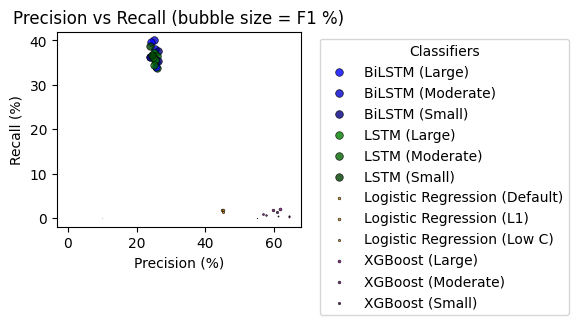

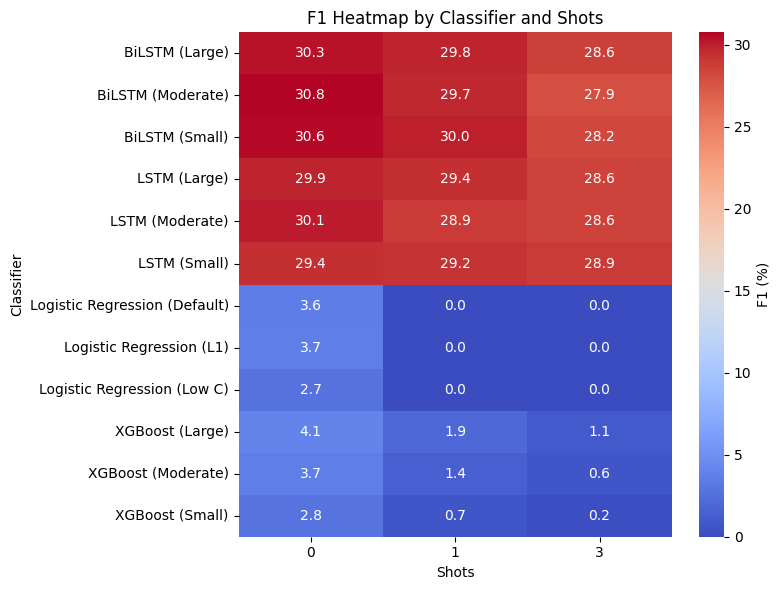

In [24]:
import seaborn as sns
import matplotlib.colors as mcolors

# Normalise scores to percentage scale (0–100)
for col in ["precision_mean", "recall_mean", "f1_mean", "exact_match_mean"]:
    lova_agg_df[col] = lova_agg_df[col] * 1.0  # if raw is already percentage, leave as-is
    if lova_agg_df[col].max() <= 1.0:  # check if it's 0–1 scale
        lova_agg_df[col] = lova_agg_df[col] * 100

# Map families to base colors
family_colors = {
    "BiLSTM": "blue",
    "LSTM": "green",
    "LogReg": "orange",
    "XGB": "purple"
}

# Function to get shade (light/med/dark) depending on variant
def get_variant_color(family, variant):
    base = mcolors.to_rgb(family_colors[family])
    factor = {"small": 0.5, "moderate": 0.8, "large": 1.0}.get(variant, 0.8)
    return tuple([c * factor for c in base])

# Extract family + variant columns
lova_agg_df["family"] = lova_agg_df["classifier"].str.extract(r"(^[A-Za-z]+)")
lova_agg_df["variant"] = lova_agg_df["classifier"].str.extract(r"(small|moderate|large|default|l1|lowC)")

# Label mapping
label_map = {
    "BiLSTM_small": "BiLSTM (Small)",
    "BiLSTM_moderate": "BiLSTM (Moderate)",
    "BiLSTM_large": "BiLSTM (Large)",
    "LSTM_small": "LSTM (Small)",
    "LSTM_moderate": "LSTM (Moderate)",
    "LSTM_large": "LSTM (Large)",
    "LogReg_default": "Logistic Regression (Default)",
    "LogReg_l1": "Logistic Regression (L1)",
    "LogReg_lowC": "Logistic Regression (Low C)",
    "XGB_small": "XGBoost (Small)",
    "XGB_moderate": "XGBoost (Moderate)",
    "XGB_large": "XGBoost (Large)",
}

lova_agg_df["pretty_label"] = lova_agg_df["classifier"].map(label_map)

# --- Scatterplot ---
plt.figure(figsize=(6,3))
for row in lova_agg_df.itertuples():
    col = get_variant_color(row.family, str(row.variant))
    plt.scatter(row.precision_mean, row.recall_mean, 
                s=row.f1_mean,
                color=col, alpha=0.8, edgecolor="k", linewidth=0.5,
                label=row.pretty_label if row.shots==0 else None)

plt.xlabel("Precision (%)")
plt.ylabel("Recall (%)")
plt.title("Precision vs Recall (bubble size = F1 %)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", title="Classifiers")
plt.tight_layout()
plt.savefig("./figs/lova_precision_recall_scatter.png", dpi=300)
plt.show()

# --- Heatmap ---
heatmap_df = lova_agg_df.pivot(index="pretty_label", columns="shots", values="f1_mean")

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "F1 (%)"})
plt.title("F1 Heatmap by Classifier and Shots")
plt.ylabel("Classifier")
plt.xlabel("Shots")
plt.tight_layout()
plt.savefig("./figs/lova_f1_heatmap.png", dpi=300)
plt.show()

## RQ4: When leveraging self-attention mechanisms in SLMs, what is the additional resource overhead compared to a zero-shot baseline?

In [25]:
# Function to summarize timing + throughput stats
def summarise(df, title):
    if df.empty:
        print(f"\n{title}: (no data)")
        return None
    
    # base timing summary
    g = df.groupby("phase")["wall_clock_s"]
    out = pd.DataFrame({
        "count": g.count(),
        "median_s": g.median(),
        "iqr_s": g.quantile(0.75) - g.quantile(0.25),
        "sum_s": g.sum()
    }).reset_index().sort_values("sum_s", ascending=False)
    
    # throughput (if code_len is present)
    if "code_len" in df.columns:
        df = df.copy()
        df["files_per_s"] = 1.0 / df["wall_clock_s"]
        df["lines_per_s"] = df["code_len"] / df["wall_clock_s"]
        g2 = df.groupby("phase")[["files_per_s", "lines_per_s"]]
        out["median_files_per_s"] = g2.median()["files_per_s"].values
        out["median_lines_per_s"] = g2.median()["lines_per_s"].values
    
    print(f"\n=== {title} ===")
    display(out)
    return out

# Summarise each log
summaries = {}
for name, df in logs.items():
    summaries[name] = summarise(df, name)


=== Baseline ===


,phase,count,median_s,iqr_s,sum_s,median_files_per_s,median_lines_per_s
0,Baseline_LM_infer,298,7.231213,2.713183,2363.097202,0.138289,4.603709
1,Baseline_Postproc,298,0.000284,0.000035,0.086108,3517.535987,NaN



=== LoVA Precompute ===


,phase,count,median_s,iqr_s,sum_s,median_files_per_s,median_lines_per_s
1,LoVA_LM_infer+attn_extract,300,111.655302,207.892561,52877.683903,281.504749,NaN
0,LoVA_Cache_write,300,0.003552,0.002445,1.746506,0.008956,0.29137



=== LoVA Train/Infer ===


,phase,count,median_s,iqr_s,sum_s
0,LoVA_Train,10,29.123204,3.552454,285.890328


In [26]:
# ---------- Config ----------
model_name   = "deepseek-ai/deepseek-coder-1.3b-base"
shots        = 0
classifier   = "BiLSTM_moderate"
cv_dir       = "data/cv"
attn_cache   = "cache/attn_matrices"
cls_cache    = "cache/attn_classifiers"
measure_out  = "measure/lova_predict_only.jsonl"
device       = "cuda" if torch.cuda.is_available() else "cpu"
batch_size   = 16

# # ---------- Collate identical to training/eval ----------
# def collate_fn(batch):
#     Xs, ys, metas = zip(*batch)
#     lengths = [x.size(0) for x in Xs]

#     padded_X = pad_sequence(Xs, batch_first=True)
#     padded_y = pad_sequence(ys, batch_first=True)

#     mask = torch.zeros(len(Xs), padded_X.size(1), dtype=torch.bool)
#     for i, l in enumerate(lengths):
#         mask[i, :l] = 1

#     return padded_X, padded_y, mask, metas

# ---------- Load test set from fold_5 ----------
test_path = os.path.join(cv_dir, "fold_5", "test.json")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Missing test split: {test_path}")

test_dataset = AttnDataset(
    json_path=test_path,
    model_name=model_name,
    cache_dir=attn_cache,
    shots=shots,
    device=device,
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

# For classifier input dim, peek one batch
peek_batch = next(iter(test_loader))
input_dim  = peek_batch[0].size(-1)

# ---------- Locate all trained classifiers (fold_0..4) ----------
model_id = model_name.replace("/", "_")
clf_dir  = os.path.join(cls_cache, model_id, f"{shots}_shot", classifier)
clf_paths = [os.path.join(clf_dir, f"fold_{i}.pt") for i in range(5)]

# ---------- Count test set examples and lines ----------
n_examples = 0
total_lines = 0
for X, y, mask, _ in test_loader:
    n_examples += X.size(0)
    total_lines += mask.sum().item()

# ---------- Evaluate each classifier ----------
results = []
for fold_idx, ckpt_path in enumerate(clf_paths):
    if not os.path.exists(ckpt_path):
        print(f"[WARN] Missing checkpoint: {ckpt_path}")
        continue

    lova = Lova(device=device, shots=shots, classifier_name=classifier)
    lova.load_classifier(ckpt_path, input_dim=input_dim)

    torch.cuda.empty_cache() if device == "cuda" else None
    t0 = time.perf_counter()
    metrics = lova.evaluate(test_loader)
    t1 = time.perf_counter()

    wall_clock_s = t1 - t0
    files_per_s  = n_examples / wall_clock_s if wall_clock_s > 0 else float("nan")
    lines_per_s  = total_lines / wall_clock_s if wall_clock_s > 0 else float("nan")

    record = {
        "phase": "LoVA_PredictOnly",
        "fold": fold_idx,
        "wall_clock_s": wall_clock_s,
        "files_per_s": files_per_s,
        "lines_per_s": lines_per_s,
        "classifier": classifier,
        "shots": shots,
        "model": model_name,
        "n_examples": n_examples,
        "total_lines": int(total_lines),
        "precision": metrics["precision"],
        "recall": metrics["recall"],
        "f1": metrics["f1"],
    }
    results.append(record)

    print(f"Fold {fold_idx}: wall_clock={wall_clock_s:.3f}s "
          f"| files/s={files_per_s:.2f} | lines/s={lines_per_s:.1f} "
          f"| F1={metrics['f1']*100:.2f}")

# ---------- Save JSONL ----------
os.makedirs(os.path.dirname(measure_out), exist_ok=True)
with open(measure_out, "a") as f:
    for rec in results:
        f.write(json.dumps(rec) + "\n")

# ---------- Aggregate stats ----------
df = pd.DataFrame(results)
print("\n=== Aggregated Prediction-Only Stats (fold_0..4 on fold_5 test set) ===")
print(df[["wall_clock_s","files_per_s","lines_per_s","precision","recall","f1"]].describe().T)


Fold 0: wall_clock=1.589s | files/s=879.21 | lines/s=24885.3 | F1=3116.70
Fold 1: wall_clock=1.439s | files/s=970.89 | lines/s=27480.2 | F1=3096.03
Fold 2: wall_clock=1.575s | files/s=886.97 | lines/s=25104.9 | F1=3093.23
Fold 3: wall_clock=1.348s | files/s=1036.44 | lines/s=29335.6 | F1=3082.90
Fold 4: wall_clock=1.234s | files/s=1132.51 | lines/s=32054.9 | F1=2992.24

=== Aggregated Prediction-Only Stats (fold_0..4 on fold_5 test set) ===
              count          mean          std           min           25%  \
wall_clock_s    5.0      1.436855     0.151225      1.233538      1.347885   
files_per_s     5.0    981.203038   106.460800    879.208735    886.968247   
lines_per_s     5.0  27772.189927  3013.290247  24885.320390  25104.947343   
precision       5.0     25.037453     0.985890     23.844852     24.584246   
recall          5.0     39.982464     1.483223     38.053485     39.017975   
f1              5.0     30.762199     0.485210     29.922417     30.828994   

        